In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS
from src.graficos import plot_coeficientes, plot_comparar_metricas_modelos
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados
)

sns.set_theme(style='white', palette='bright')

In [2]:
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Construção do modelo de classificação

In [3]:
X = df.drop(columns=['Species'])
y = df['Species']

le = LabelEncoder()

y = le.fit_transform(y)

In [4]:
le.classes_

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [5]:
le.inverse_transform([0, 1, 2])

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [6]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

Aplicamos agora o pré-processamento de escala e também vamos comparar a performance de dois modelos classificadores.

In [7]:
preprocessamento = Pipeline(
    [('scaler', StandardScaler())]
    )

In [8]:
classificadores = {
    'DummyClassifier': {
        'preprocessor': None,
        'classificador': DummyClassifier(strategy='stratified')
    },
    'LogisticRegression': {
        'preprocessor': preprocessamento, 
        'classificador': LogisticRegression()
    }
}

In [9]:
resultados = { 
    nome_modelo: treinar_e_validar_modelo_classificacao(
        X, y, kf, **classificador, multi_class=True
    )
    for nome_modelo, classificador in classificadores.items()
}

df_resultados = organiza_resultados(resultados)
df_resultados

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1_weighted,test_precision_weighted,test_recall_weighted,test_roc_auc_ovr,test_average_precision,time_seconds
0,DummyClassifier,0.0,0.0,0.36,0.36152,0.354004,0.367228,0.36,0.445577,0.314818,0.0
1,DummyClassifier,0.0,0.015006,0.42,0.422794,0.413824,0.432406,0.42,0.489825,0.335741,0.015006
2,DummyClassifier,0.001226,0.005964,0.4,0.403186,0.395662,0.393333,0.4,0.415255,0.310327,0.007189
3,LogisticRegression,0.0,0.012378,1.0,1.0,1.0,1.0,1.0,1.0,0.7713,0.012378
4,LogisticRegression,0.003,0.000695,0.92,0.919118,0.92,0.92,0.92,0.995172,0.762167,0.003695
5,LogisticRegression,0.0,0.015007,0.94,0.941176,0.939948,0.940972,0.94,0.997623,0.842977,0.015007


In [10]:
df_resultados.groupby('model').mean().sort_values('test_accuracy')

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1_weighted,test_precision_weighted,test_recall_weighted,test_roc_auc_ovr,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.000409,0.00699,0.393333,0.395833,0.38783,0.397656,0.393333,0.450219,0.320295,0.007398
LogisticRegression,0.001,0.00936,0.953333,0.953431,0.953316,0.953657,0.953333,0.997599,0.792148,0.01036


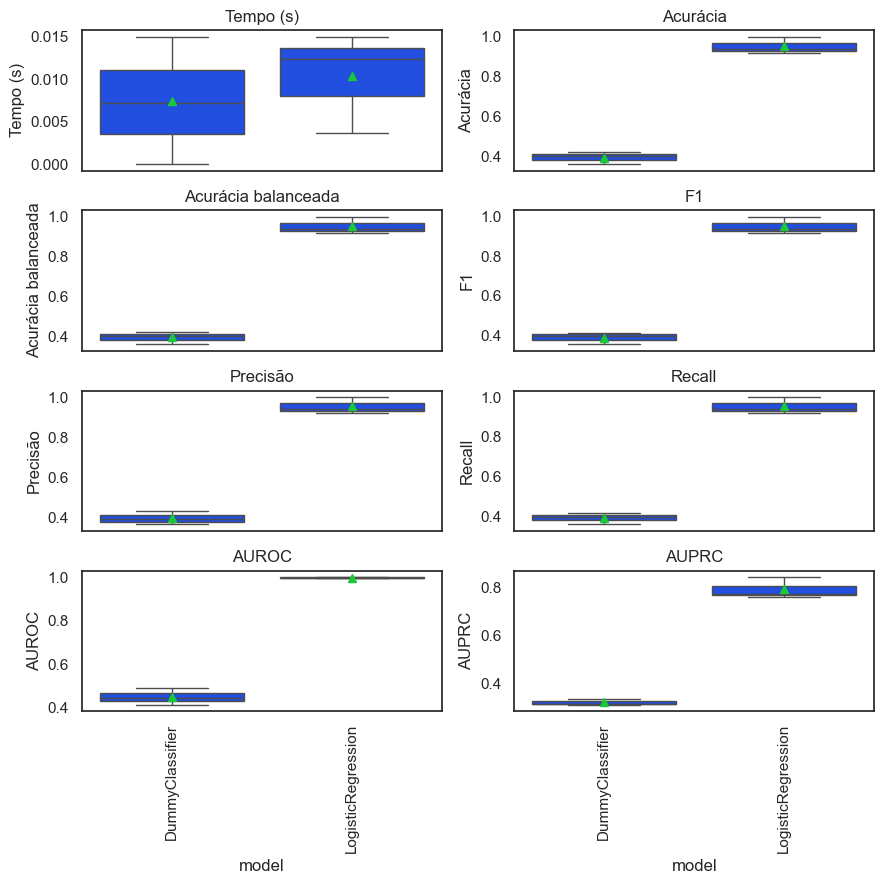

In [11]:
plot_comparar_metricas_modelos(df_resultados, multi_class=True)

O modelo de LogisticRegression se demonstrou mais performático em comparação com o DummyClassifier.

In [12]:
param_grid = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2', None],
    'clf__class_weight': [None, 'balanced']
}

In [13]:
clf = LogisticRegression(solver='saga')

grid_search = grid_search_cv_classificador(
    clf, param_grid, kf, preprocessamento, refit_metric='accuracy', multi_class=True
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('scaler',
                                                         StandardScaler())])),
                                       ('clf',
                                        LogisticRegression(solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__penalty': ['l1', 'l2', None]},
             refit='accuracy',
             scoring=['accuracy', 'balanced_accuracy', 'f1_weighted',
                      'precision_weighted', 'recall_weighted', 'roc_auc_ovr',
                      'average_precision'],
             verbose=1)

In [14]:
grid_search.fit(X, y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


c:\Users\Samuel\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Samuel\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('scaler',
                                                         StandardScaler())])),
                                       ('clf',
                                        LogisticRegression(solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__penalty': ['l1', 'l2', None]},
             refit='accuracy',
             scoring=['accuracy', 'balanced_accuracy', 'f1_weighted',
                      'precision_weighted', 'recall_weighted', 'roc_auc_ovr',
                      'average_precision'],
             verbose=1)

In [15]:
grid_search.best_params_

{'clf__C': 0.1, 'clf__class_weight': None, 'clf__penalty': None}

In [16]:
grid_search.best_score_

np.float64(0.9733333333333333)

In [17]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', StandardScaler())])),
                ('clf',
                 LogisticRegression(C=0.1, penalty=None, solver='saga'))])

In [18]:
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X) 

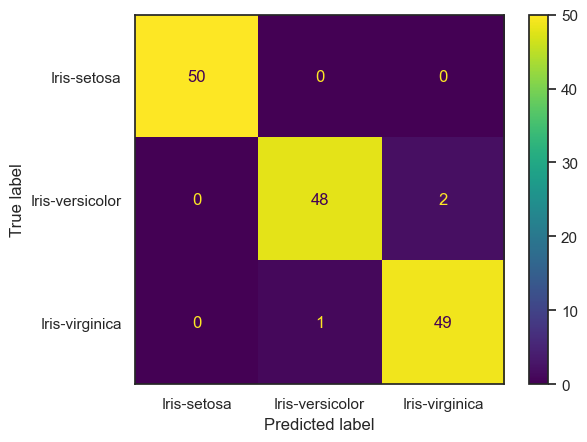

In [19]:
cm = confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

disp.plot()

In [20]:
print(classification_report(y, y_pred, target_names=le.classes_))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        50
Iris-versicolor       0.98      0.96      0.97        50
 Iris-virginica       0.96      0.98      0.97        50

       accuracy                           0.98       150
      macro avg       0.98      0.98      0.98       150
   weighted avg       0.98      0.98      0.98       150



## Conclusão

O dataset de Iris é um clássico e bastante útil para aprendizado de modelos classificadores. É possível construir algoritmos pouco complexos e obter resultados satisfatórios, já que a base é bastante balanceada e classes linearmente separáveis.